In [1]:
# Define paths
import sys
sys.path.append('..')

training_path = '../data/training_data/'
verification_path = '../data/verification_data/'
results_path = 'results'
interpolating_for = 'exp'

In [2]:
# Define polynomial utilities (1D, square matrix)
import numpy as np
import sympy

def get_polynomial_matrix(interpolation_points: np.ndarray) -> np.ndarray:
    n_rows = n_cols = interpolation_points.shape[0]
    matrix = np.zeros(shape = (n_rows, n_cols))
    for col_index in range(n_cols):
        matrix[:, col_index] = interpolation_points ** col_index
    return matrix

def get_polynomial_interpolant(interpolation_points: np.ndarray, 
                               target_points: np.ndarray) -> sympy.Poly:
    matrix = get_polynomial_matrix(interpolation_points)
    coefs = np.linalg.solve(matrix, target_points)
    # coefs = np.matmul(np.linalg.inv(matrix), target_points) # WRONG APPROACH!
    return sympy.Poly.from_list(np.flip(coefs), sympy.Symbol('x'))

In [3]:
import pandas as pd

verification_data = pd.read_csv(f"{verification_path}/verification_{interpolating_for}_linspace_{90}.csv")
n_inputs = [3, 9, 27, 81, 243, 729]

# Task 1 - Interpolate

In [85]:
for N in n_inputs:
    input_data = pd.read_csv(f"{training_path}/input_{interpolating_for}_linspace_{N}.csv")
    x = input_data['x'].to_numpy()
    y = input_data['y'].to_numpy()

    interpolator = get_polynomial_interpolant(x, y)

    interpolations = []
    for point in verification_data['x']:
        interpolations += [interpolator(point)]

    pd.DataFrame(data = { 'x': verification_data['x'], 
                'y_target': verification_data['y'], 
                'interpolation': interpolations })\
        .to_csv(f'{results_path}/training_performance_{interpolating_for}_input{N}.csv',
                index=False)

# Task 2 - Evaluate interpolation performance

## 2.1 - Informal comparison

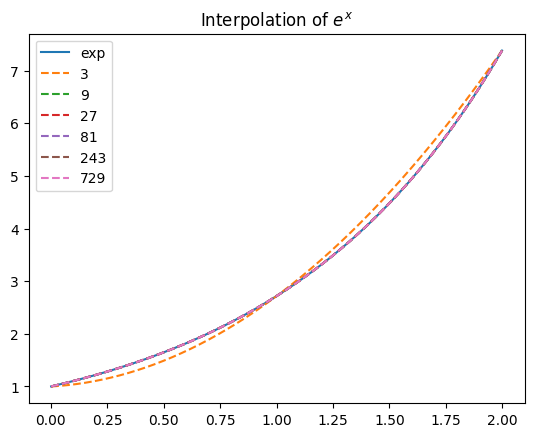

In [86]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(verification_data['x'], verification_data['y'], label = 'exp')
file_path = f'training_performance_{interpolating_for}_input'
for N in n_inputs:
    df = pd.read_csv(f'{results_path}/{file_path}{N}.csv')
    plt.plot(df['x'], df['interpolation'], label = N, linestyle='--')
plt.legend()
plt.title('Interpolation of $e^x$')
plt.show()

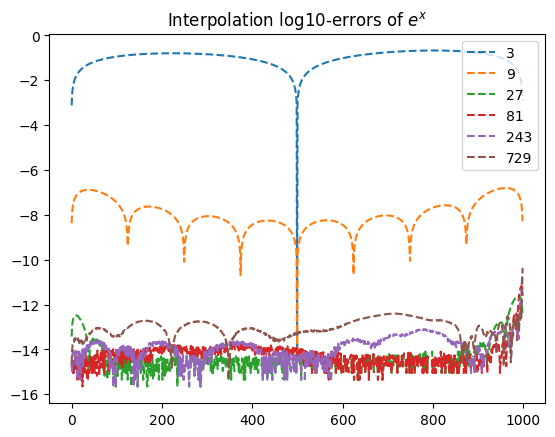

In [89]:
import matplotlib.pyplot as plt
import pandas as pd

with np.errstate(divide='ignore'): # ignore cases when division by zero appears
    for N in n_inputs:
        df = pd.read_csv(f'{results_path}/training_performance_{interpolating_for}_input{N}.csv')
        errors_list = np.log10(np.abs(df['y_target'].to_numpy() - df['interpolation'].to_numpy()))
        plt.plot(errors_list, label = N, linestyle='--')
    plt.legend()
    plt.title('Interpolation log10-errors of $e^x$')
    plt.show()

-----

In [1]:
# Define polynomial utilities (1D, rectangular matrix)
import numpy as np
import sympy

def get_polynomial_matrix(interpolation_points: np.ndarray, polynomial_degree: int = -1) -> np.ndarray:
    n_rows = interpolation_points.shape[0]
    matrix = np.zeros(shape = (n_rows, n_rows if polynomial_degree == -1 else polynomial_degree + 1))
    for col_index in range(matrix.shape[1]):
        matrix[:, col_index] = interpolation_points ** col_index
    return matrix

def get_polynomial_interpolant(interpolation_points: np.ndarray, 
                               target_points: np.ndarray, polynomial_degree: int = -1) -> sympy.Poly:
    matrix = get_polynomial_matrix(interpolation_points, polynomial_degree)
    if polynomial_degree != -1:
        target_points = np.matmul(np.transpose(matrix), target_points)
        matrix = np.matmul(np.transpose(matrix), matrix)
    coefs = np.linalg.solve(matrix, target_points)
    return sympy.Poly.from_list(np.flip(coefs.flatten()), sympy.Symbol('z'))

In [2]:
import pandas as pd

input_data = pd.read_csv(f"{training_path}/input_{interpolating_for}_linspace_{3}.csv")
x = input_data['x'].to_numpy()
y = input_data['y'].to_numpy().reshape(-1, 1)

ModuleNotFoundError: No module named 'pandas'

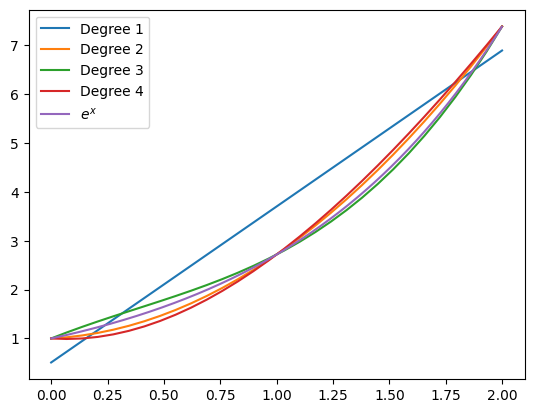

In [131]:
import matplotlib.pyplot as plt

for degree in range(1, len(x) + 2):
    interpolator = get_polynomial_interpolant(x, y, degree).as_expr() # Poly object to Expr object
    np_interpolator = sympy.lambdify(z, interpolator.as_expr(), 'numpy')
    plt.plot(np.linspace(0, 2, 30), np_interpolator(np.linspace(0, 2, 30)), label=f"Degree {degree}")
plt.plot(verification_data['x'], verification_data['y'], label = "$e^x$")
plt.legend()
plt.show()

In [74]:
sympy.Poly.from_list([1,2,3], sympy.abc.z)

Poly(z**2 + 2*z + 3, z, domain='ZZ')

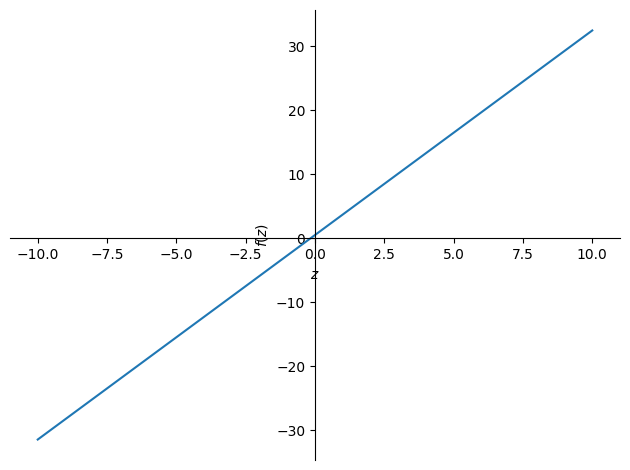

Poly(3.19452804946533*z + 0.50791792633124, z, domain='RR')

In [94]:
from sympy.abc import z
interpolator = get_polynomial_interpolant(x, y, 1)
sympy.plot(interpolator.as_expr())
interpolator

In [100]:
intee = interpolator.as_expr()


In [104]:
numpy_function = sympy.lambdify(z, interpolator.as_expr(), 'numpy')
numpy_function(np.arange(5))

array([ 0.50791793,  3.70244598,  6.89697403, 10.09150207, 13.28603012])

In [119]:
interpolator = get_polynomial_interpolant(x, y, 1).as_expr() # Poly object to Expr object
np_interpolator = sympy.lambdify(z, interpolator.as_expr(), 'numpy')
# plt.plot(np.linspace(0, 2, 30), np_interpolator(np.linspace(0, 2, 30)), label=f"Degree {degree}")
np_interpolator(np.linspace(0, 2, 30))

array([0.50791793, 0.72823021, 0.94854248, 1.16885476, 1.38916704,
       1.60947932, 1.8297916 , 2.05010388, 2.27041616, 2.49072844,
       2.71104072, 2.931353  , 3.15166528, 3.37197756, 3.59228984,
       3.81260212, 4.03291439, 4.25322667, 4.47353895, 4.69385123,
       4.91416351, 5.13447579, 5.35478807, 5.57510035, 5.79541263,
       6.01572491, 6.23603719, 6.45634947, 6.67666175, 6.89697403])

<function _lambdifygenerated(z)>